### 1. Install - Import Libraries

Install required python libraries.

In [ ]:
#!pip install -U pandas
#!pip install -U numpy
#!pip install -U torch
#!pip install -U pandas
#!pip install -U matplotlib
#!pip install -U datatile
#!pip install -U seaborn

Import python libraries.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.jit import script, trace
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

from datatile.summary.df import DataFrameSummary
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Set pytorch device to GPU cuda if present, otherwise set to CPU.

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

### 2. Import - Review Data

#### 2.1 Download corpus and set variables

Download corpus from: https://www.kaggle.com/datasets/rtatman/ubuntu-dialogue-corpus/download?datasetVersionNumber=2 and expand compressed archive in to the notebook's root folder.

Save variables for data folder, corpus name, and print first 10 lines to review data.

In [5]:
data = "./archive/" # data root folder
corpus_name = "Ubuntu-dialogue-corpus/" # corpus subfolder
corpus = os.path.join(data, corpus_name) # join
raw_data = "dialogueText.csv" # Existing raw data file
formatted_data = "formatted_dialogue_lines.txt" # Will be creaated later on

# print first 10 lines
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, raw_data))

b'folder,dialogueID,date,from,to,text\n'
b'3,126125.tsv,2008-04-23T14:55:00.000Z,bad_image,,"Hello folks, please help me a bit with the following sentence: \'Order here your personal photos or videos.\' - I think the only allowed version is \'Order your personal videos or photos here.\', but I\'m not sure, are you?"\n'
b'3,126125.tsv,2008-04-23T14:56:00.000Z,bad_image,,"Did I choose a bad channel? I ask because you seem to be dumb like windows user"\n'
b'3,126125.tsv,2008-04-23T14:57:00.000Z,lordleemo,bad_image,"the second sentence is better english   and we are not dumb"\n'
b'3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,,"Sock Puppe?t"\n'
b'3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,,"WTF?"\n'
b'3,64545.tsv,2009-08-01T06:22:00.000Z,richardcavell,mechtech,"it\'s a wikipedia term.  There is Prodigy, PRDIGY and prgidy and they\'re all the same guy"\n'
b'3,98758.tsv,2009-05-20T07:58:00.000Z,C-00000100,Severity1,"what is bartek trying to do?"\n'
b'3,98758.tsv,2009-05-20T08:01:00.000Z,C

#### 2.2 Load data - initial review and clean up

Load *'dialogueText.csv'* to pandas series object and print first 10 lines for review.

In [6]:
df = pd.read_csv(corpus + raw_data)
df.head(10)

,folder,dialogueID,date,from,to,text
0,3,126125.tsv,2008-04-23T14:55:00.000Z,bad_image,NaN,"Hello folks, please help me a bit with the fol..."
1,3,126125.tsv,2008-04-23T14:56:00.000Z,bad_image,NaN,Did I choose a bad channel? I ask because you ...
2,3,126125.tsv,2008-04-23T14:57:00.000Z,lordleemo,bad_image,the second sentence is better english and we...
3,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,Sock Puppe?t
4,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,WTF?
5,3,64545.tsv,2009-08-01T06:22:00.000Z,richardcavell,mechtech,"it's a wikipedia term. There is Prodigy, PRDI..."
6,3,98758.tsv,2009-05-20T07:58:00.000Z,C-00000100,Severity1,what is bartek trying to do?
7,3,98758.tsv,2009-05-20T08:01:00.000Z,C-00000100,Severity1,is he trying to play online video?
8,3,98758.tsv,2009-05-20T08:04:00.000Z,C-00000100,Severity1,"bartek go here, if this doesn't play then it g..."
9,3,86303.tsv,2010-08-24T19:56:00.000Z,pozic,Somelauw,the algorithms from aptitude were ported to ap...


Drop unused columns to save processing time and remove *'.tsv'* from **dialogueID**.
Print first 10 lines for review.

In [7]:
df.drop(['folder', 'date'], axis=1, inplace=True)
df['dialogueID'] = df['dialogueID'].str.replace(r'.tsv', '', regex=True)
df.head(10)

,dialogueID,from,to,text
0,126125,bad_image,NaN,"Hello folks, please help me a bit with the fol..."
1,126125,bad_image,NaN,Did I choose a bad channel? I ask because you ...
2,126125,lordleemo,bad_image,the second sentence is better english and we...
3,64545,mechtech,NaN,Sock Puppe?t
4,64545,mechtech,NaN,WTF?
5,64545,richardcavell,mechtech,"it's a wikipedia term. There is Prodigy, PRDI..."
6,98758,C-00000100,Severity1,what is bartek trying to do?
7,98758,C-00000100,Severity1,is he trying to play online video?
8,98758,C-00000100,Severity1,"bartek go here, if this doesn't play then it g..."
9,86303,pozic,Somelauw,the algorithms from aptitude were ported to ap...


Use DataFrameSummary method to review data column statistics.

In [8]:
DataFrameSummary(df).columns_stats

/opt/anaconda3/envs/uninlp/lib/python3.8/site-packages/datatile/summary/df.py:39: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.corr = df.corr()


,dialogueID,from,to,text
counts,1038324,1038311,566035,1038237
uniques,346108,164083,149488,863907
missing,0,13,472289,87
missing_perc,0%,0%,45.49%,0.01%
types,categorical,categorical,categorical,categorical


Drop null values from 'text' and 'from' columns. The 'to' column has a lot of missing values but this is expected since all first comments are adressed to null. Review column statistics again.

In [9]:
df.dropna(subset=['text', 'from'], inplace=True)
DataFrameSummary(df).columns_stats

/opt/anaconda3/envs/uninlp/lib/python3.8/site-packages/datatile/summary/df.py:39: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  self.corr = df.corr()


,dialogueID,from,to,text
counts,1038224,1038224,566029,1038224
uniques,346108,164077,149488,863895
missing,0,0,472195,0
missing_perc,0%,0%,45.48%,0%
types,categorical,categorical,categorical,categorical


### 3. Data Transformation & Analysis

#### 3.1 Transform data to Input Output pairs

Convert dataframe to dictionary using dataframe's index as key and row values as nested dictionary. Print example.

In [10]:
#Convert dataframe to dictionary using dataframes index as key and row values as nested dictionary.
conv_dict = df.to_dict('index')

# print example
conv_dict[0]

{'dialogueID': '126125',
 'from': 'bad_image',
 'to': nan,
 'text': "Hello folks, please help me a bit with the following sentence: 'Order here your personal photos or videos.' - I think the only allowed version is 'Order your personal videos or photos here.', but I'm not sure, are you?"}

Define helper functions for combining consecutive text from the same person to one input and for extracting input-ouput pairs from conversations.

In [11]:
# Combine consecutive text from same person to one sentence
def combine_text(dictionary):
    for key in reversed(dictionary):
        if key+1 in dictionary and dictionary[key]['from'] == dictionary[key+1]['from']:
            dictionary[key+1]['text'] = str(dictionary[key]['text']) + " " + str(dictionary[key+1]['text'])
            dictionary[key]['from'] = "del"  

    for key, value in dict(dictionary).items():
        if value['from'] == "del":
                del dictionary[key] 
                
    return dictionary   

# Extracts input output pairs from conversations
def extract_pairs(conversations):
    qa_pairs = []
        # Iterate over all the lines of the conversation
    for key in conversations:
        if key+1 in conversations and conversations[key]['dialogueID'] == conversations[key+1]['dialogueID']:
            inputLine = str(conversations[key]['text']).strip()
            targetLine = str(conversations[key+1]['text']).strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs                         

Set deliniter and new file path, run **combine_text** and **extract_pairs** functions, and write results to *"formatted_dialogue_lines.txt"* file. Print 10 lines to review data.

In [12]:
'''
Apply combine text and extract pairs functions that complete data transformation
'''
# Set delimiter
delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Define path to new file
datafile = os.path.join(corpus, formatted_data)

print("\nProcessing corpus into lines and conversation pairs...")
dictionary = combine_text(conv_dict)
pairs = extract_pairs(dictionary)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in pairs:
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(os.path.join(corpus, formatted_data))         


Processing corpus into lines and conversation pairs...

Writing newly formatted file...

Sample lines from file:
b"Hello folks, please help me a bit with the following sentence: 'Order here your personal photos or videos.' - I think the only allowed version is 'Order your personal videos or photos here.', but I'm not sure, are you? Did I choose a bad channel? I ask because you seem to be dumb like windows user\tthe second sentence is better english   and we are not dumb\n"
b"Sock Puppe?t WTF?\tit's a wikipedia term.  There is Prodigy, PRDIGY and prgidy and they're all the same guy\n"
b"is there any reason why my 'network manager' icon in my tray does not scale when the other ones get resized when i change the size of the panel?\tprobably not a vector icon\n"
b"probably not a vector icon\tthe other icons aren't vector icons either.\n"
b"I installed the 64bit version of ubuntu and I can't open firefox(segfault) and if I try to open nautilus nothing happens and my cpu goes 100%, what can

#### 3.2 Data Analysis

Load data from *"formatted_dialogue_lines.txt"* file to pandas object for data analysis. Set dataframe labels, and print first 10 lines.

In [13]:
labels  = ["input", "output"]
df = pd.read_csv(corpus + formatted_data, sep="\t", header=None, names=labels )
df.head(10)

,input,output
0,"Hello folks, please help me a bit with the fol...",the second sentence is better english and we...
1,Sock Puppe?t WTF?,"it's a wikipedia term. There is Prodigy, PRDI..."
2,is there any reason why my 'network manager' i...,probably not a vector icon
3,probably not a vector icon,the other icons aren't vector icons either.
4,I installed the 64bit version of ubuntu and I ...,i sent you a link on how to install 32 bit
5,"ok, anyone know how I set bios password in ubu...",you'd need to set that in your BIOS.
6,Hello Does Ubuntu have somekind of register to...,Linux doesn't have an equivalent to the Window...
7,how do i generate an xorg.conf file? for intel...,"'sudo xorg -configure', I think"
8,Where does synoptic install the programs to? L...,Synaptic installs the programs to wherever the...
9,are there any utils that will do a repair of y...,repair in the sense? clean up of unused files ?


Plot input and output text length histogram. 

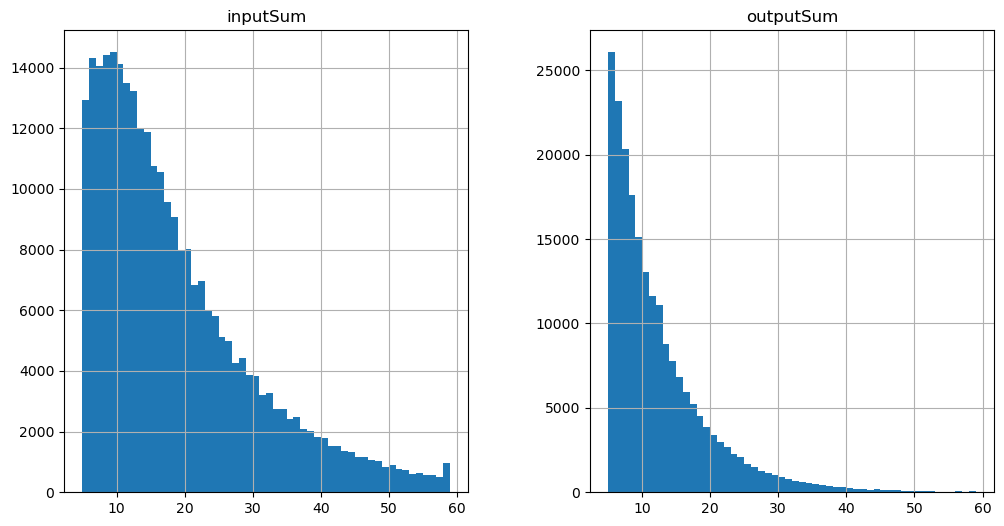

In [23]:
df['inputSum'] = df['input'].apply(lambda x: len(x.split(' '))) # Sum input text per row
df['outputSum'] = df['output'].apply(lambda x: len(x.split(' ')))  # Sum output text per row
df_sum = df[['inputSum', 'outputSum']] # set temp df
#df_sum.plot(kind='hist', bins=range(5, 60, 1), grid=True); # plot histogram


fig, axis = plt.subplots(1,2,figsize=(12, 6))
df_sum.hist(ax=axis, bins=range(5, 60, 1));

Set maximum text length to consider.

In [13]:
MAX_LENGTH = 10  # Maximum text length to consider

In [14]:
input_word_count = df['input'].str.split(expand=True).stack().value_counts(ascending=True)

<AxesSubplot:>

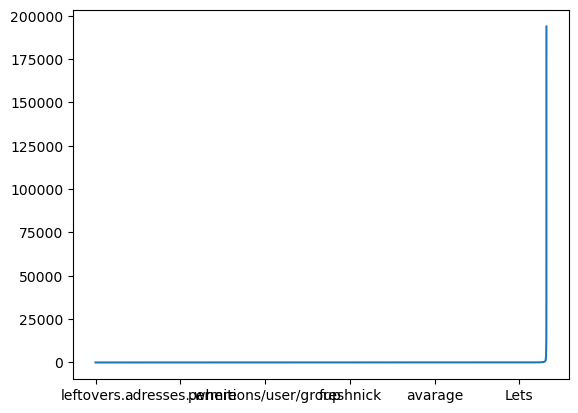

In [15]:
input_word_count.plot()

Set minimum word count threshold for trimming.

In [16]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

### 4. Pre-Processing

#### 4.1 Vocabulary helper class

Let's now create a vocabulary and load query/response sentence pairs into memory.

Remember that we are dealing with sequences of words, which do not have an implicit mapping to a discrete numerical space. A mapping must be created by mapping each unique word in the dataset to an index value.

The Voc class keeps a mapping from words to indexes, a reverse mapping of indexes to words, a count of each word and a total word count. The class provides methods for adding a word to the vocabulary (addWord), adding all words in a sentence (addSentence) and trimming infrequently seen words (trim).

In [17]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)
            

#### 4.2 Normalisation helper functions

Let's  also write some functions to clean the text.

1. Convert Unicode strings to ASCII using unicodeToAscii
2. Convert all letters to lowercase and trim all non-letter characters except for basic punctuation (normalizeString)
3. Filter out sentences with length greater than the MAX_LENGTH threshold (filterPairs) to facilitate training convergence.

In [18]:


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r'\w+.com\s?','',s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p, max_length):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length

# Filter pairs using filterPair condition
def filterPairs(pairs, max_length):
    return [pair for pair in pairs if filterPair(pair, max_length)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, max_length):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs, max_length)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs

In [20]:
# Load/Assemble voc and pairs
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, MAX_LENGTH)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 341547 sentence pairs
Trimmed to 154837 sentence pairs
Counting words...
Counted words: 70083

pairs:
['probably not a vector icon', 'the other icons aren t vector icons either.']
['ok anyone know how i set bios password in ubuntu already set', 'you d need to set that in your bios.']
['how do i generate an xorg.conf file? for intel gmas', 'sudo xorg configure i think']
['can use a udev rule for it', 'thanks']
['parsi chmod parsi to the file', '']
['since jaunty is still beta all issues discussions go in ubuntu channel please', 'thnx']
['can someone giv me a link in ubuntu wiki to install sun java', '']
['itsux bu i use deskyop version shall i use server one', 'yes. postfix dovecot tend to make a decent email stack.']
['can anyone mend an nfs alternative that works transparently?', 'once you get nfs set up it is transparent']
['http www.article.pl?sid article on ubuntu.', 'sloooow']


To achieve faster convergence during training, we are trimming rarely used words out of our vocabulary using the *MIN_COUNT* threshold we've set in **3.2 Data Analysis** section. We first call the *voc.trim* function and then we filter out the pairs with trimmed words.

In [21]:
def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index or len(word) < 1:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index or len(word) < 1:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)
for pair in pairs[:10]:
    print(pair)

keep_words 20570 / 70080 = 0.2935
Trimmed from 154837 pairs to 107895, 0.6968 of total
['probably not a vector icon', 'the other icons aren t vector icons either.']
['ok anyone know how i set bios password in ubuntu already set', 'you d need to set that in your bios.']
['can use a udev rule for it', 'thanks']
['since jaunty is still beta all issues discussions go in ubuntu channel please', 'thnx']
['they ve been replaced by dejavu fonts', 'cool! thank you.']
['can t you alt middle click and resize them?', 'that doesn t work for me']
['against the upgrade tool', 'thanks']
['hints on how to get nvidia driver to work?', 'help.community binarydriverhowto nvidia']
['help.community binarydriverhowto nvidia', 'thanks']
['probably. look at the bios for puter not here. !', 'ok thanks i thought it was something you did in the os']


#### 4.3 Embedding, Padding, Mini-Batches

Using mini-batches heps to speed up training and also leverage GPU parallelization capabilities.

Using mini-batches also means that we must be mindful of the variation of sentence length in our batches. To accommodate sentences of different sizes in the same batch, we will make our batched input tensor of shape (max_length, batch_size), where sentences shorter than the max_length are zero padded after an EOS_token.

If we simply convert our English sentences to tensors by converting words to their indexes(indexesFromSentence) and zero-pad, our tensor would have shape (batch_size, max_length) and indexing the first dimension would return a full sequence across all time-steps. However, we need to be able to index our batch along time, and across all sequences in the batch. Therefore, we transpose our input batch shape to (max_length, batch_size), so that indexing across the first dimension returns a time step across all sentences in the batch. We handle this transpose implicitly in the zeroPadding function.

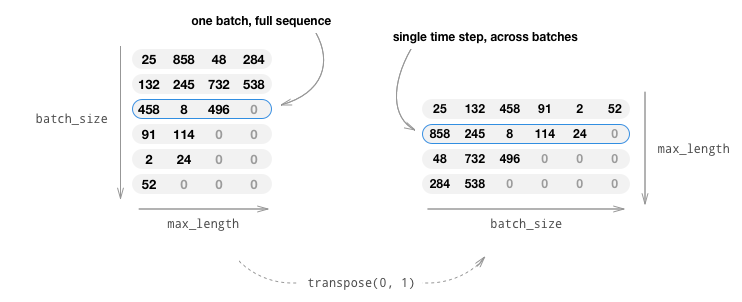


The inputVar function handles the process of converting sentences to tensor, ultimately creating a correctly shaped zero-padded tensor. It also returns a tensor of lengths for each of the sequences in the batch which will be passed to our decoder later.

The outputVar function performs a similar function to inputVar, but instead of returning a lengths tensor, it returns a binary mask tensor and a maximum target sentence length. The binary mask tensor has the same shape as the output target tensor, but every element that is a PAD_token is 0 and all others are 1.

batch2TrainData simply takes a bunch of pairs and returns the input and target tensors using the aforementioned functions.

In [22]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    #print(l)
    #for sentence in l:
    #    print(indexesFromSentence(voc, sentence))
    #print()
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    #print(padVar)
    #print(lengths)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    #print()
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)


input_variable: tensor([[  871,    69,    54,  2510,   535],
        [   25,    47,  4403,  1829,   757],
        [  185,    95,   172,     2,     2],
        [   25,     5, 15502,     0,     0],
        [   60,  9893,   148,     0,     0],
        [   28,    29,   172,     0,     0],
        [  125,   464,   155,     0,     0],
        [ 1122,  1290,     2,     0,     0],
        [  379,    47,     0,     0,     0],
        [   37,  3554,     0,     0,     0],
        [ 8450,     2,     0,     0,     0],
        [    2,     0,     0,     0,     0]])
lengths: tensor([12, 11,  8,  3,  3])
target_variable: tensor([[1242,   18,  592,   48,   14],
        [  18,  294,    2,    2,   48],
        [ 375,   12,    0,    0,    2],
        [ 372,  216,    0,    0,    0],
        [  29, 4413,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False, False,  True],
      

Let's now build our Encoder network. The encoder RNN iterates through the input sentence one token (e.g. word) at a time, at each time step outputting an “output” vector and a “hidden state” vector. The hidden state vector is then passed to the next time step, while the output vector is recorded. The encoder transforms the context it saw at each point in the sequence into a set of points in a high-dimensional space, which the decoder will use to generate a meaningful output for the given task.

Let's use a Bi-directional RNN to build our Encoder network.

### 5. Seq2Seq Model

#### 5.1 Encoder class

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

#### 5.2 Luong attention class

In [24]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

#### 5.3 Decoder class

In [25]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

### 6 Model Training Procedure

#### 6.1 Masked loss

Since we are dealing with batches of padded sequences, we cannot simply consider all elements of the tensor when calculating loss. We define maskNLLLoss to calculate our loss based on our decoder’s output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor. This loss function calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor.

In [26]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    #loss = loss.to(device)
    return loss, nTotal.item()

#### 6.2 Train function

The train function contains the algorithm for a single training iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

The first trick is using teacher forcing. This means that at some probability, set by teacher_forcing_ratio, we use the current target word as the decoder’s next input rather than using the decoder’s current guess. This technique acts as training wheels for the decoder, aiding in more efficient training. However, teacher forcing can lead to model instability during inference, as the decoder may not have a sufficient chance to truly craft its own output sequences during training. Thus, we must be mindful of how we are setting the teacher_forcing_ratio, and not be fooled by fast convergence.
The second trick that we implement is gradient clipping. This is a commonly used technique for countering the “exploding gradient” problem. In essence, by clipping or thresholding gradients to a maximum value, we prevent the gradients from growing exponentially and either overflow (NaN), or overshoot steep cliffs in the cost function.

In [27]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio,max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    #input_variable = input_variable.to(device)
    #target_variable = target_variable.to(device)
    #mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    #decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]
    

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    #print('max_target_len: ', max_target_len)

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            #decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal


    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

#### 6.3 Training iterations

The trainIters function is responsible for running n_iterations of training given the passed models, optimizers, data, etc. This function is quite self explanatory, as we have done the heavy lifting with the train function.

One thing to note is that when we save our model, we save a tarball containing the encoder and decoder state_dicts (parameters), the optimizers’ state_dicts, the loss, the iteration, etc. Saving the model in this way will give us the ultimate flexibility with the checkpoint. After loading a checkpoint, we will be able to use the model parameters to run inference, or we can continue training right where we left off.

In [28]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, hidden_size, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, teacher_forcing_ratio):

    # Load batches for each  iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    #if loadFilename:
    #    start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

#### 6.4 Greedy decoding

Greedy decoding is the decoding method that we use during training when we are NOT using teacher forcing. In other words, for each time step, we simply choose the word from decoder_output with the highest softmax value. This decoding method is optimal on a single time-step level.

In [29]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], dtype=torch.long)
        all_scores = torch.zeros([0])
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

### 7. Model Tuning

### 7. Model Training

Model configuration variables.

In [32]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

save_dir = os.path.join(data, "save")
save_dir



In [33]:
print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
#if loadFilename:
#    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
#if loadFilename:
#    encoder.load_state_dict(encoder_sd)
#    decoder.load_state_dict(decoder_sd)
# Use appropriate device
#encoder = encoder.to(device)
#decoder = decoder.to(device)
print('Models built and ready to go!')

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 250
save_every = 1000

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

#if loadFilename:
#    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
#    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()


Building encoder and decoder ...
Models built and ready to go!
Building optimizers ...


Training iterations.

In [35]:
# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, hidden_size, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, teacher_forcing_ratio)


Starting Training!
Initializing ...
Training...
Iteration: 250; Percent complete: 6.2%; Average loss: 6.1854
Iteration: 500; Percent complete: 12.5%; Average loss: 5.4730
Iteration: 750; Percent complete: 18.8%; Average loss: 5.2182
Iteration: 1000; Percent complete: 25.0%; Average loss: 5.0459
Iteration: 1250; Percent complete: 31.2%; Average loss: 4.9522
Iteration: 1500; Percent complete: 37.5%; Average loss: 4.8455
Iteration: 1750; Percent complete: 43.8%; Average loss: 4.7501
Iteration: 2000; Percent complete: 50.0%; Average loss: 4.6875
Iteration: 2250; Percent complete: 56.2%; Average loss: 4.6142
Iteration: 2500; Percent complete: 62.5%; Average loss: 4.5336
Iteration: 2750; Percent complete: 68.8%; Average loss: 4.4793
Iteration: 3000; Percent complete: 75.0%; Average loss: 4.4074
Iteration: 3250; Percent complete: 81.2%; Average loss: 4.3949
Iteration: 3500; Percent complete: 87.5%; Average loss: 4.3301
Iteration: 3750; Percent complete: 93.8%; Average loss: 4.2867
Iteration: 

### 8. Model Evaluation

Evaluate on text

Now that we have our decoding method defined, we can write functions for evaluating a string input sentence. The evaluate function manages the low-level process of handling the input sentence. We first format the sentence as an input batch of word indexes with batch_size==1. We do this by converting the words of the sentence to their corresponding indexes, and transposing the dimensions to prepare the tensor for our models. We also create a lengths tensor which contains the length of our input sentence. In this case, lengths is scalar because we are only evaluating one sentence at a time (batch_size==1). Next, we obtain the decoded response sentence tensor using our GreedySearchDecoder object (searcher). Finally, we convert the response’s indexes to words and return the list of decoded words.

evaluateInput acts as the user interface for our chatbot. When called, an input text field will spawn in which we can enter our query sentence. After typing our input sentence and pressing Enter, our text is normalized in the same way as our training data, and is ultimately fed to the evaluate function to obtain a decoded output sentence. We loop this process, so we can keep chatting with our bot until we enter either “q” or “quit”.

Finally, if a sentence is entered that contains a word that is not in the vocabulary, we handle this gracefully by printing an error message and prompting the user to enter another sentence.

In [36]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    #input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

In [37]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

Once, the training is finished, we can now load the saved model and run evaluation.

In [38]:
# Set checkpoint to load from; set to None if starting from scratch
loadFilename = True
checkpoint_iter = n_iteration # get the last checkpoint
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint.tar'.format(checkpoint_iter))

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']

if loadFilename:
    embedding.load_state_dict(embedding_sd)

if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)


In [39]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)


Bot: hi
Bot: i think you can use the ubuntu server
Bot: i think
Bot: i m not sure what you want to do?
Bot: i think you can get it with sudo
Bot: np
Bot: i m not sure
Bot: i don t know what it s the same thing
Bot: thanks
